## EPFL sample B 5.668 GHz 97 mK reflection

![alt text](image.png)

In [3]:
import pandas as pd
import numpy as np  
# from scipy import find_peaks
import matplotlib.pyplot as plt
import cmath
import math as m
from scipy.signal import find_peaks, peak_widths, savgol_filter
from scipy.optimize import curve_fit, leastsq
from pylab import *
import glob
from datetime import *



In [4]:
def remove_outlier_points(freq, S11, threshold=2):
    """
    Remove outlier points from S11 data based on z-score threshold.
    freq: numpy array of frequencies
    S11: numpy array of S11 magnitude (linear or dB scale)
    threshold: z-score threshold to identify outliers
    Returns filtered freq and S11 arrays
    """
    # Calculate z-scores
    mean = np.mean(S11)
    std = np.std(S11)
    z_scores = np.abs((S11 - mean) / std)
    
    # Create mask for points within threshold
    mask = z_scores < threshold
    
    # Return filtered arrays
    return freq[mask], S11[mask]

In [5]:
def fit_s21_magnitude(freq, logMag_dB,p0 = [
        2*np.pi*5.6610840e9,           # wc (rad/s)
        2*np.pi*2e5,        # kex (rad/s)
        2*np.pi*5e4,         # k0 (rad/s)
        1.0,               # A (amplitude scaling)
    ]):
    # Convert to linear scale
    S11_linear = 10**(logMag_dB / 20)
    omega = 2 * np.pi * freq
    
    # Model for magnitude-only fitting
    def s21_magnitude_model(w, p):
        wc, kex, k0, A = p
        S11=((kex-k0)+2j*(w-wc))/((kex+k0)-2j*(w-wc))
        return A * np.abs(S11)
    
    # Residuals for magnitude fitting
    def residuals_mag(p, mag_data, w):
        model_mag = s21_magnitude_model(w, p)
        return model_mag - mag_data
    
    # Initial guess
    wc_guess = 2*np.pi*5.66e9
    
    
    
    # Fit
    try:
        plsq = leastsq(residuals_mag, p0, args=(S11_linear, omega))
        p_final = plsq[0]
        return p_final,S11_linear
    except Exception as e:
        print(f"Fitting failed: {e}")
        return None, S11_linear

def analyze_s21_logmag(freq, logMag,pump_power,filename):
    """
    Complete analysis pipeline for freq + logMag data
    """
    p_final, S11_linear = fit_s21_magnitude(freq, logMag)
    
    wc_fit, kex_fit, k0_fit, A_fit = p_final
    w=freq * 2 * np.pi
    # Print results
    print(f"=== Analysis Results for {filename} ===")
    print("=== Fitted Parameters ===")
    print(f"Resonance frequency (Hz): {wc_fit/(2*np.pi):.6e}")
    print(f"internal damping k₀ (Hz): {k0_fit/(2*np.pi):.1f}")
    print(f"Coupling rate k_ex (Hz): {kex_fit/(2*np.pi):.1f}")
    print(f"total damping k_tot (Hz): {(kex_fit+k0_fit)/(2*np.pi):.1f}")
    print(f"Amplitude scaling factor A: {A_fit:.6f}")    

    s11_fit_complex = ((kex_fit-k0_fit)+2j*(w-wc_fit))/((kex_fit+k0_fit)-2j*(w-wc_fit))
    s11_fit_mag = A_fit * np.abs(s11_fit_complex)
    s11_fit_dB = 20 * np.log10(s11_fit_mag)
        
        # Plot results
    plt.figure(figsize=(12, 8))
        
        # Plot in dB scale
    plt.subplot(2, 1, 1)
    plt.plot(freq, logMag, 'b.', label='Measured |S21| (dB)', alpha=0.7)
    plt.plot(freq, s11_fit_dB, 'r--', linewidth=2, label='Fit |S21| (dB)')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('|S21| (dB)')
    plt.title(f'S21 Magnitude Fit (dB Scale) : Pump Power = {pump_power} dB')
    
    plt.grid(True)
        
        # Plot in linear scale
    plt.subplot(2, 1, 2)
    plt.plot(freq, S11_linear, 'b.', label='Measured |S21| (linear)', alpha=0.7)
    plt.plot(freq,  s11_fit_mag, 'r--', linewidth=2, label='Fit |S21| (linear)')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('|S21| (linear)')
    plt.title(f'S21 Magnitude Fit (Linear Scale) : Pump Power = {pump_power} dB')
    
    plt.grid(True)
    plt.figtext(0.5, -0.05, f'Simulated for {filename}', ha='center', fontsize=12.5, fontweight='bold')    
    plt.tight_layout()
    plt.show()
        
    return p_final




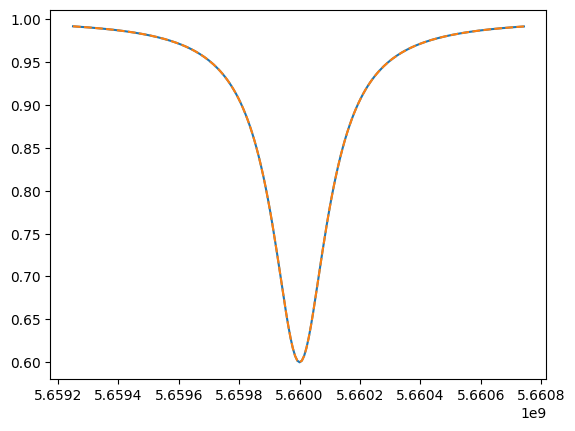

In [6]:
wc=2*np.pi*5.66e9
kex=2*np.pi*2e5
k0=2*np.pi*5e4
ktot=kex+k0
w=wc+arange(-1,1,0.01)*3*ktot
figure(1)
S11=((kex-k0)+2j*(w-wc))/((kex+k0)-2j*(w-wc))
plot(w/(2*pi),abs(S11),'-',label='refl')

wc=2*np.pi*5.66e9
kex=2*np.pi*2e5
k0=2*np.pi*5e4
ktot=kex+k0
w=wc+arange(-1,1,0.01)*3*ktot
figure(1)
S11=((kex-k0)+2j*(w-wc))/((kex+k0)-2j*(w-wc))
plot(w/(2*np.pi),abs(S11),'--',label='refl')

# plt.legend()
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('|S11|')
# plt.title('Reflection coefficient S11 vs Frequency')
# plt.figtext(0.5, -0.05, 'Simulated S11 for two parameter sets', ha='center', fontsize=15, fontweight='bold')
# plt.tight_layout()

=== Analysis Results for 1735723904_97.0mK_-70.0dBmprobe_OFFTWPApump_-40.0dBm5.6610840GHzoptopump_2.0MHz9.32ms107.3HzZI.txt ===
=== Fitted Parameters ===
Resonance frequency (Hz): 5.661079e+09
internal damping k₀ (Hz): 286693.0
Coupling rate k_ex (Hz): 474575.0
total damping k_tot (Hz): 761268.1
Amplitude scaling factor A: 0.000570


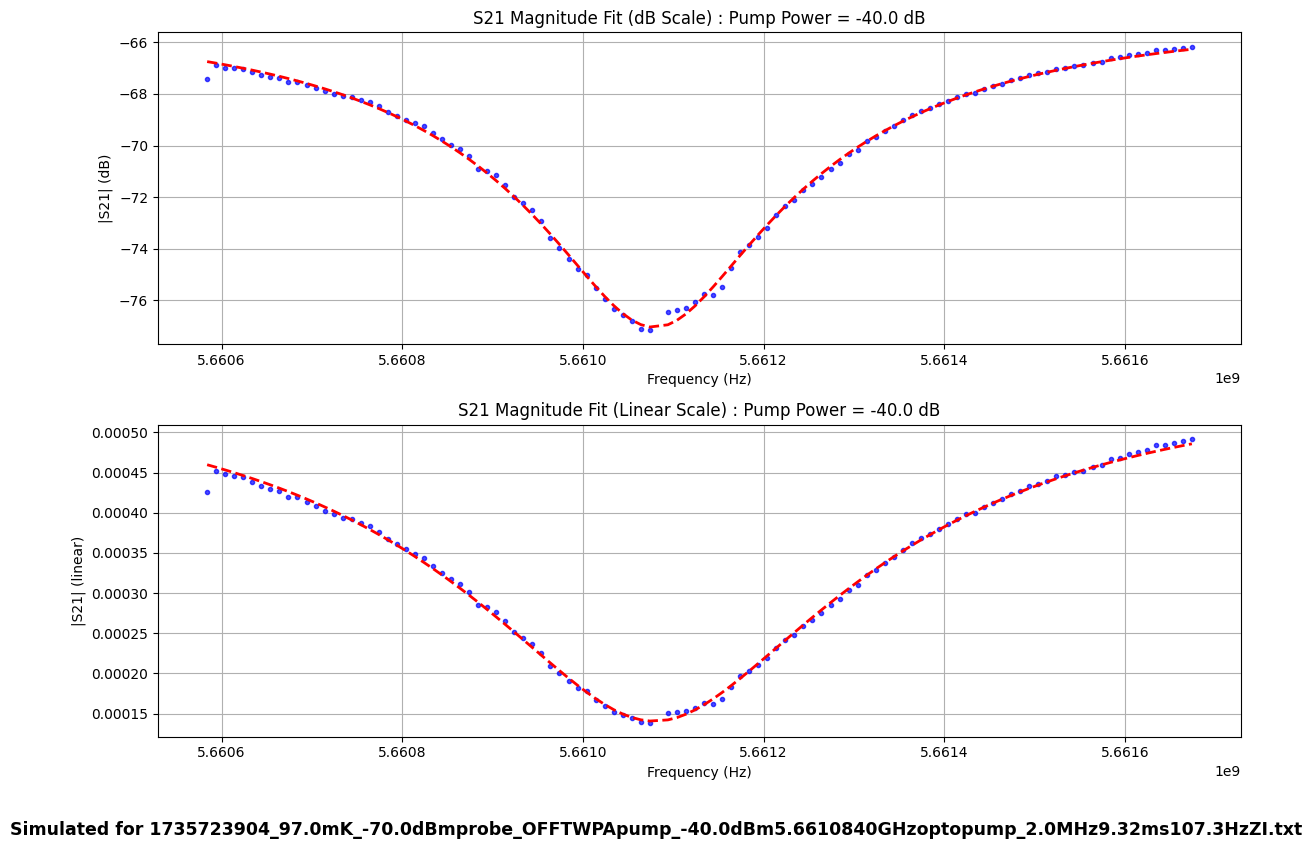

=== Analysis Results for 1735724036_97.0mK_-80.0dBmprobe_OFFTWPApump_-40.0dBm5.6610840GHzoptopump_2.0MHz9.32ms107.3HzZI.txt ===
=== Fitted Parameters ===
Resonance frequency (Hz): 5.661079e+09
internal damping k₀ (Hz): 292607.8
Coupling rate k_ex (Hz): 490581.9
total damping k_tot (Hz): 783189.7
Amplitude scaling factor A: 0.000184


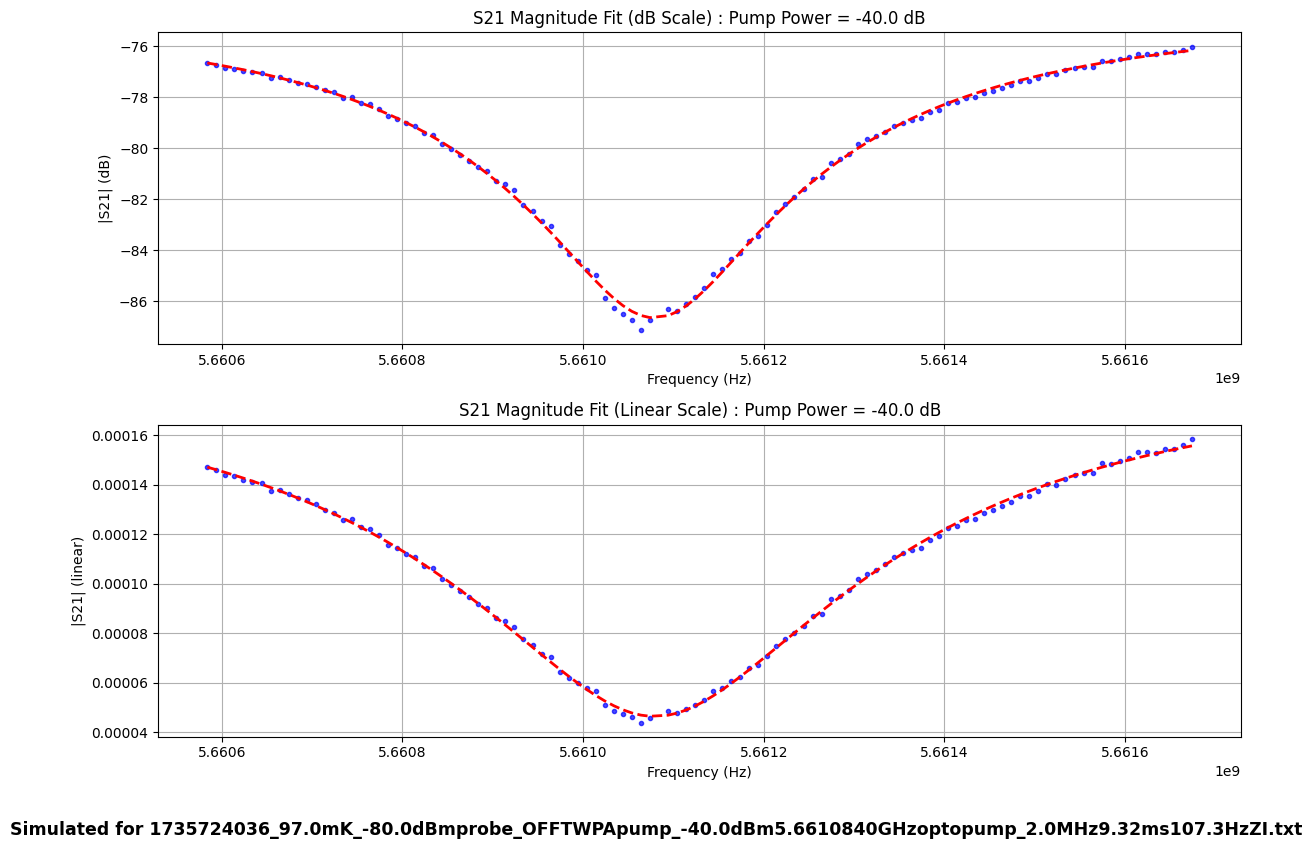

=== Analysis Results for 1735742350_97.0mK_-70.0dBmprobe_OFFTWPApump_-40.0dBm5.6610840GHzoptopump_2.0MHz9.32ms107.3HzZI.txt ===
=== Fitted Parameters ===
Resonance frequency (Hz): 5.661083e+09
internal damping k₀ (Hz): 309076.6
Coupling rate k_ex (Hz): 498493.5
total damping k_tot (Hz): 807570.1
Amplitude scaling factor A: 0.000578


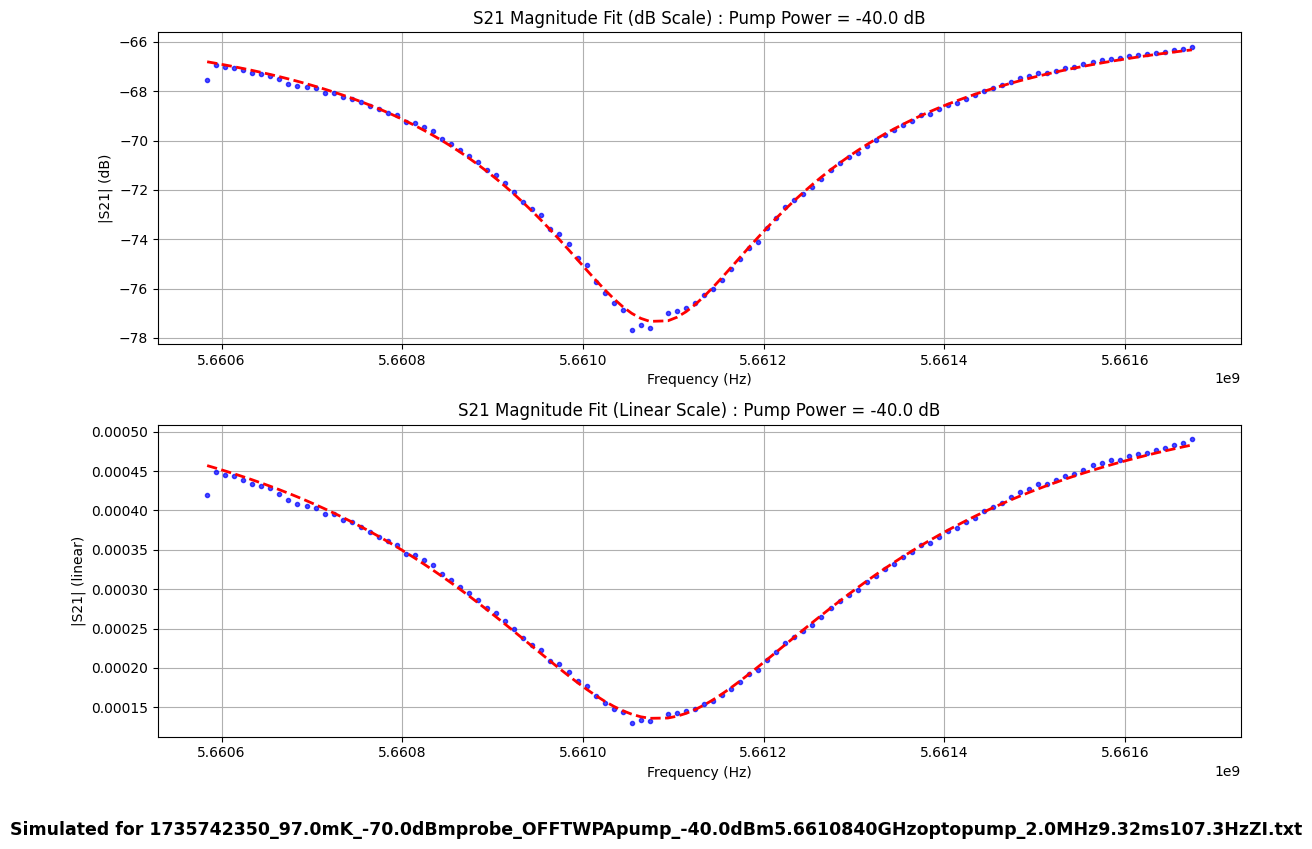

=== Analysis Results for 1735742482_97.0mK_-80.0dBmprobe_OFFTWPApump_-40.0dBm5.6610840GHzoptopump_2.0MHz9.32ms107.3HzZI.txt ===
=== Fitted Parameters ===
Resonance frequency (Hz): 5.661081e+09
internal damping k₀ (Hz): 308153.3
Coupling rate k_ex (Hz): 505151.6
total damping k_tot (Hz): 813304.9
Amplitude scaling factor A: 0.000185


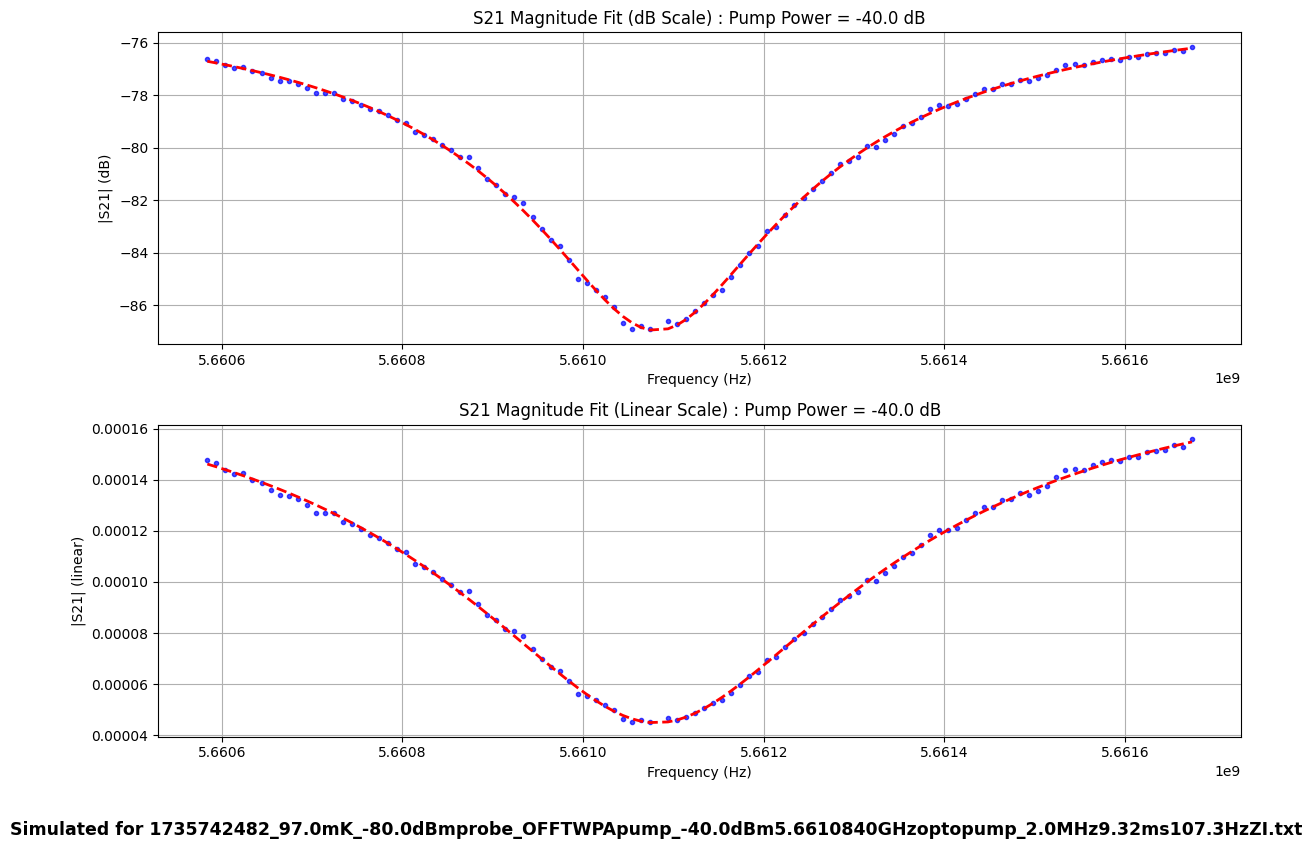

=== Analysis Results for 1735744694_97.0mK_-70.0dBmprobe_OFFTWPApump_-30.0dBm5.6611720GHzoptopump_2.0MHz9.32ms107.3HzZI.txt ===
=== Fitted Parameters ===
Resonance frequency (Hz): 5.661153e+09
internal damping k₀ (Hz): 242362.8
Coupling rate k_ex (Hz): 510482.0
total damping k_tot (Hz): 752844.8
Amplitude scaling factor A: 0.000594


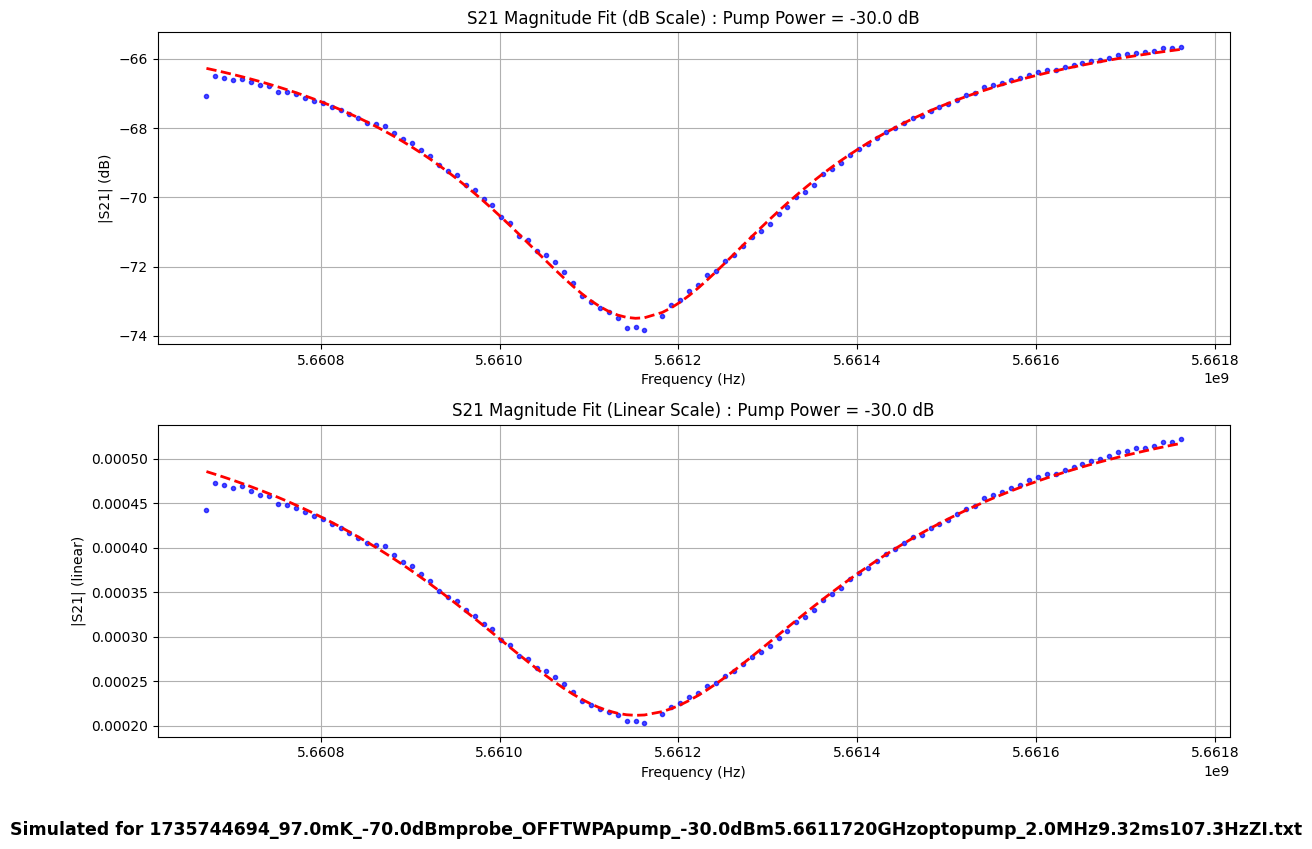

=== Analysis Results for 1735744826_97.0mK_-80.0dBmprobe_OFFTWPApump_-30.0dBm5.6611720GHzoptopump_2.0MHz9.32ms107.3HzZI.txt ===
=== Fitted Parameters ===
Resonance frequency (Hz): 5.661155e+09
internal damping k₀ (Hz): 233051.5
Coupling rate k_ex (Hz): 502428.3
total damping k_tot (Hz): 735479.8
Amplitude scaling factor A: 0.000187


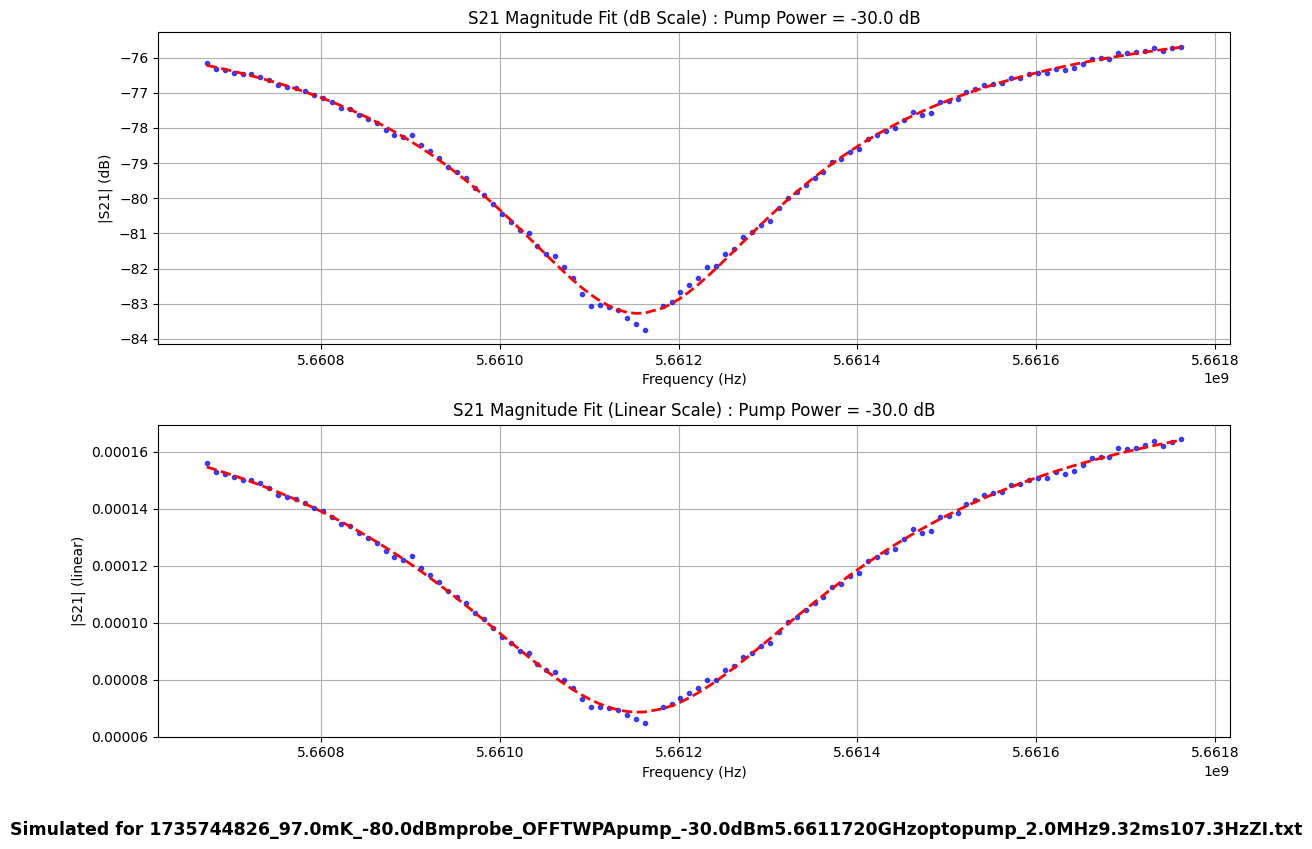

=== Analysis Results for 1735808070_97.0mK_-70.0dBmprobe_OFFTWPApump_-30.0dBm5.6611720GHzoptopump_2.0MHz9.32ms107.3HzZI.txt ===
=== Fitted Parameters ===
Resonance frequency (Hz): 5.661161e+09
internal damping k₀ (Hz): 230362.8
Coupling rate k_ex (Hz): 502046.5
total damping k_tot (Hz): 732409.3
Amplitude scaling factor A: 0.000596


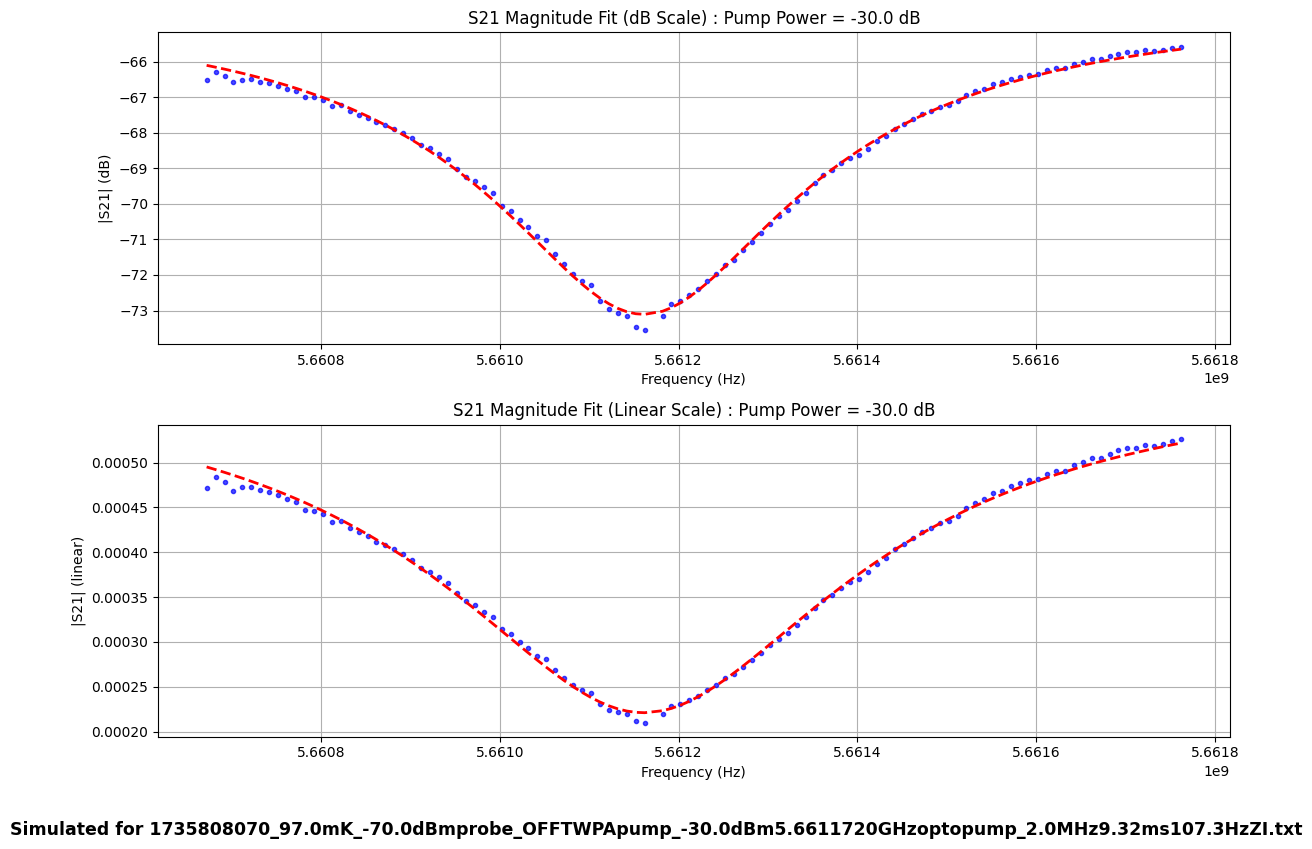

=== Analysis Results for 1735808203_97.0mK_-80.0dBmprobe_OFFTWPApump_-30.0dBm5.6611720GHzoptopump_2.0MHz9.32ms107.3HzZI.txt ===
=== Fitted Parameters ===
Resonance frequency (Hz): 5.661160e+09
internal damping k₀ (Hz): 233674.3
Coupling rate k_ex (Hz): 511826.5
total damping k_tot (Hz): 745500.8
Amplitude scaling factor A: 0.000192


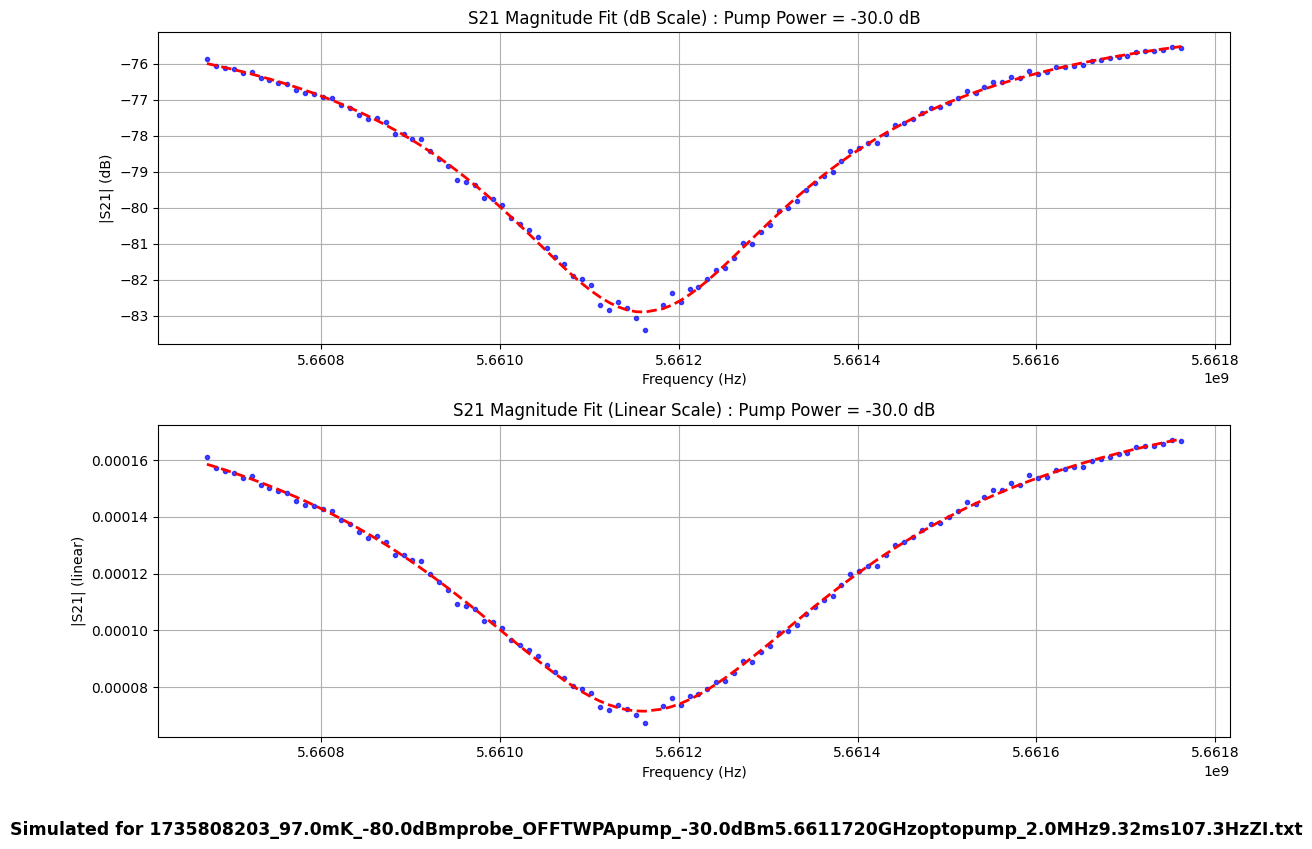

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import leastsq


folder='EPFL sample B 5.668 GHz 97 mK reflection'
filenames01=['1735723904_97.0mK_-70.0dBmprobe_OFFTWPApump_-40.0dBm5.6610840GHzoptopump_2.0MHz9.32ms107.3HzZI.txt', 
           "1735724036_97.0mK_-80.0dBmprobe_OFFTWPApump_-40.0dBm5.6610840GHzoptopump_2.0MHz9.32ms107.3HzZI.txt",
           '1735742350_97.0mK_-70.0dBmprobe_OFFTWPApump_-40.0dBm5.6610840GHzoptopump_2.0MHz9.32ms107.3HzZI.txt',
           '1735742482_97.0mK_-80.0dBmprobe_OFFTWPApump_-40.0dBm5.6610840GHzoptopump_2.0MHz9.32ms107.3HzZI.txt',
          ]
filenames02=[ '1735744694_97.0mK_-70.0dBmprobe_OFFTWPApump_-30.0dBm5.6611720GHzoptopump_2.0MHz9.32ms107.3HzZI.txt',
           '1735744826_97.0mK_-80.0dBmprobe_OFFTWPApump_-30.0dBm5.6611720GHzoptopump_2.0MHz9.32ms107.3HzZI.txt',
           '1735808070_97.0mK_-70.0dBmprobe_OFFTWPApump_-30.0dBm5.6611720GHzoptopump_2.0MHz9.32ms107.3HzZI.txt',
           '1735808203_97.0mK_-80.0dBmprobe_OFFTWPApump_-30.0dBm5.6611720GHzoptopump_2.0MHz9.32ms107.3HzZI.txt']

pump_power= -40.0 # dBm
for filename in filenames01:
    freq=[]
    S11=[]
    f=open(folder+'\\'+filename,'r')
    data=f.readlines()
    f.close()
    for line in data[1:]:
            fields=line.split('\t')
            freq.append(float(fields[0]))
            S11.append(float(fields[1]))
    freq=array(freq)
    logMag=array(S11)
    # freq_clean, logMag_clean = remove_outlier_points(freq, logMag)
    p_fitted = analyze_s21_logmag(freq, logMag, pump_power,filename)

pump_power = -30.0 # dBm
for filename in filenames02:
    freq=[]
    S11=[]
    f=open(folder+'\\'+filename,'r')
    data=f.readlines()
    f.close()
    for line in data[1:]:
                fields=line.split('\t')
                freq.append(float(fields[0]))
                S11.append(float(fields[1]))
    freq=array(freq)
    logMag=array(S11)
    # freq_clean, logMag_clean = remove_outlier_points(freq, logMag)
    p_fitted = analyze_s21_logmag(freq, logMag, pump_power,filename)

In [10]:
# calculating avg and uncertainty of k_ext and k_0 for -70 db for both pump powers and two datasets
print("=== Average and Uncertainty of k_ext and k_0 for -70 db ===")
kex_values_40db = [498494.4,474575.3]
k0_values_40db = [286693.2,309077.1]
kex_values_30db = [510480.5,502045.0]
k0_values_30db = [242362.1,230362.1]
print(f"Average k_ext for -70 dBm, -40 dBm pump: {np.mean(kex_values_40db):.2f} ± {np.abs(kex_values_40db[0]-kex_values_40db[1])/2:.2f} Hz")
print(f"Average k_0 for -70 dBm, -40 dBm pump: {np.mean(k0_values_40db):.2f} ± {np.abs(k0_values_40db[0]-k0_values_40db[1])/2:.2f} Hz")
print(f"Average k_ext for -70 dBm, -30 dBm pump: {np.mean(kex_values_30db):.2f} ± {np.abs(kex_values_30db[0]-kex_values_30db[1])/2:.2f} Hz")
print(f"Average k_0 for -70 dBm, -30 dBm pump: {np.mean(k0_values_30db):.2f} ± {np.abs(k0_values_30db[0]-k0_values_30db[1])/2:.2f} Hz")

=== Average and Uncertainty of k_ext and k_0 for -70 db ===
Average k_ext for -70 dBm, -40 dBm pump: 486534.85 ± 11959.55 Hz
Average k_0 for -70 dBm, -40 dBm pump: 297885.15 ± 11191.95 Hz
Average k_ext for -70 dBm, -30 dBm pump: 506262.75 ± 4217.75 Hz
Average k_0 for -70 dBm, -30 dBm pump: 236362.10 ± 6000.00 Hz


In [11]:
# calculating avg and uncertainty of k_ext and k_0 for -70 db for both pump powers and two datasets

print("=== Average and Uncertainty of k_ext and k_0 for -80 db ===")
kex_values_40db = [505151.4,490581.9]
k0_values_40db = [308153.2,292607.8]
kex_values_30db = [511826.4,502427.9]
k0_values_30db = [233674.2,233051.3]
print(f"Average k_ext for -80 dBm, -40 dBm pump: {np.mean(kex_values_40db):.2f} ± {np.abs(kex_values_40db[0]-kex_values_40db[1])/2:.2f} Hz")
print(f"Average k_0 for -80 dBm, -40 dBm pump: {np.mean(k0_values_40db):.2f} ± {np.abs(k0_values_40db[0]-k0_values_40db[1])/2:.2f} Hz")
print(f"Average k_ext for -80 dBm, -30 dBm pump: {np.mean(kex_values_30db):.2f} ± {np.abs(kex_values_30db[0]-kex_values_30db[1])/2:.2f} Hz")
print(f"Average k_0 for -80 dBm, -30 dBm pump: {np.mean(k0_values_30db):.2f} ± {np.abs(k0_values_30db[0]-k0_values_30db[1])/2:.2f} Hz")

=== Average and Uncertainty of k_ext and k_0 for -80 db ===
Average k_ext for -80 dBm, -40 dBm pump: 497866.65 ± 7284.75 Hz
Average k_0 for -80 dBm, -40 dBm pump: 300380.50 ± 7772.70 Hz
Average k_ext for -80 dBm, -30 dBm pump: 507127.15 ± 4699.25 Hz
Average k_0 for -80 dBm, -30 dBm pump: 233362.75 ± 311.45 Hz


## new section


In [10]:
def fit_s21_magnitude(freq, logMag_dB,p0 = [
        2*np.pi*5.6610840e9,           # wc (rad/s)
        2*np.pi*209466.3,        # kex (rad/s)
        2*np.pi*371751.7,         # k0 (rad/s)
        1.0,               # A (amplitude scaling)
    ]):
    # Convert to linear scale
    S11_linear = 10**(logMag_dB / 20)
    omega = 2 * np.pi * freq
    
    # Model for magnitude-only fitting
    def s21_magnitude_model(w, p):
        wc, kex, k0, A = p
        S11=1-(2*kex*k0/((k0+1j*kex)*((kex+k0)+2j*(w-wc))))
        return A * np.abs(S11)
    
    # Residuals for magnitude fitting
    def residuals_mag(p, mag_data, w):
        model_mag = s21_magnitude_model(w, p)
        return model_mag - mag_data
    
    # Initial guess
    wc_guess = 2*np.pi*5.66e9
    
    
    
    # Fit
    try:
        plsq = leastsq(residuals_mag, p0, args=(S11_linear, omega))
        p_final = plsq[0]
        return p_final,S11_linear
    except Exception as e:
        print(f"Fitting failed: {e}")
        return None, S11_linear

def analyze_s21_logmag(freq, logMag,pump_power,filename):
    """
    Complete analysis pipeline for freq + logMag data
    """
    p_final, S11_linear = fit_s21_magnitude(freq, logMag)
    
    wc_fit, kex_fit, k0_fit, A_fit = p_final
    w=freq * 2 * np.pi
    # Print results
    print(f"=== Analysis Results for {filename} ===")
    print("=== Fitted Parameters ===")
    print(f"Resonance frequency (Hz): {wc_fit/(2*np.pi):.6e}")
    print(f"internal damping k₀ (Hz): {k0_fit/(2*np.pi):.1f}")
    print(f"Coupling rate k_ex (Hz): {kex_fit/(2*np.pi):.1f}")
    print(f"total damping k_tot (Hz): {(kex_fit+k0_fit)/(2*np.pi):.1f}")
    print(f"Amplitude scaling factor A: {A_fit:.6f}")    

    s11_fit_complex = 1-(2*kex_fit*k0_fit/((k0_fit+1j*kex_fit)*((kex_fit+k0_fit)+2j*(w-wc_fit))))
    s11_fit_mag = A_fit * np.abs(s11_fit_complex)
    s11_fit_dB = 20 * np.log10(s11_fit_mag)
        
        # Plot results
    plt.figure(figsize=(12, 8))
        
        # Plot in dB scale
    plt.subplot(2, 1, 1)
    plt.plot(freq, logMag, 'b.', label='Measured |S21| (dB)', alpha=0.7)
    plt.plot(freq, s11_fit_dB, 'r--', linewidth=2, label='Fit |S21| (dB)')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('|S21| (dB)')
    plt.title(f'S21 Magnitude Fit (dB Scale) : Pump Power = {pump_power} dB')
    
    plt.grid(True)
        
        # Plot in linear scale
    plt.subplot(2, 1, 2)
    plt.plot(freq, S11_linear, 'b.', label='Measured |S21| (linear)', alpha=0.7)
    plt.plot(freq,  s11_fit_mag, 'r--', linewidth=2, label='Fit |S21| (linear)')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('|S21| (linear)')
    plt.title(f'S21 Magnitude Fit (Linear Scale) : Pump Power = {pump_power} dB')
    
    plt.grid(True)
    plt.figtext(0.5, -0.05, f'Simulated for {filename}', ha='center', fontsize=12.5, fontweight='bold')    
    plt.tight_layout()
    plt.show()
        
    return p_final




=== Analysis Results for 1735723904_97.0mK_-70.0dBmprobe_OFFTWPApump_-40.0dBm5.6610840GHzoptopump_2.0MHz9.32ms107.3HzZI.txt ===
=== Fitted Parameters ===
Resonance frequency (Hz): 5.661238e+09
internal damping k₀ (Hz): 371697.6
Coupling rate k_ex (Hz): 209434.3
total damping k_tot (Hz): 581131.9
Amplitude scaling factor A: 0.000466


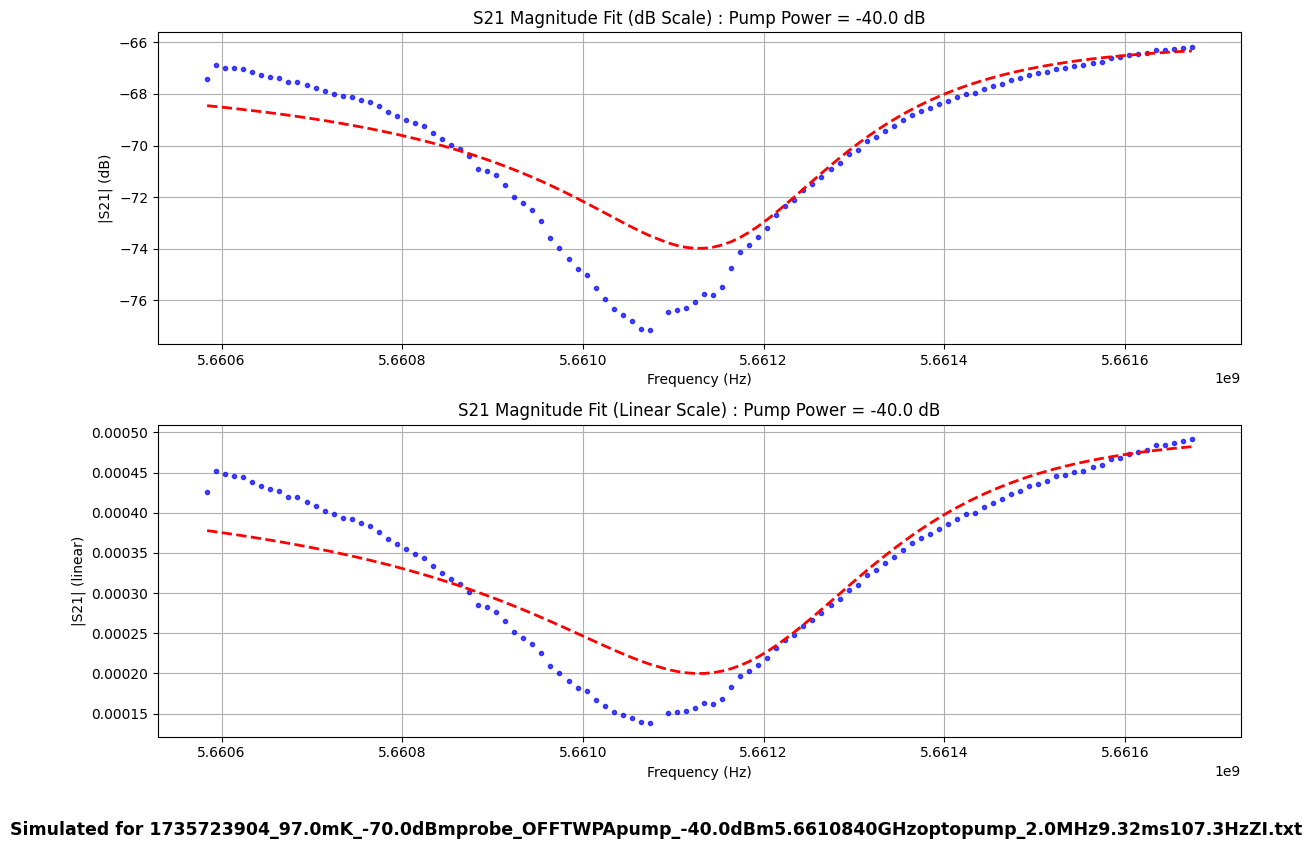

=== Analysis Results for 1735724036_97.0mK_-80.0dBmprobe_OFFTWPApump_-40.0dBm5.6610840GHzoptopump_2.0MHz9.32ms107.3HzZI.txt ===
=== Fitted Parameters ===
Resonance frequency (Hz): 5.661237e+09
internal damping k₀ (Hz): 383459.0
Coupling rate k_ex (Hz): 210911.3
total damping k_tot (Hz): 594370.3
Amplitude scaling factor A: 0.000150


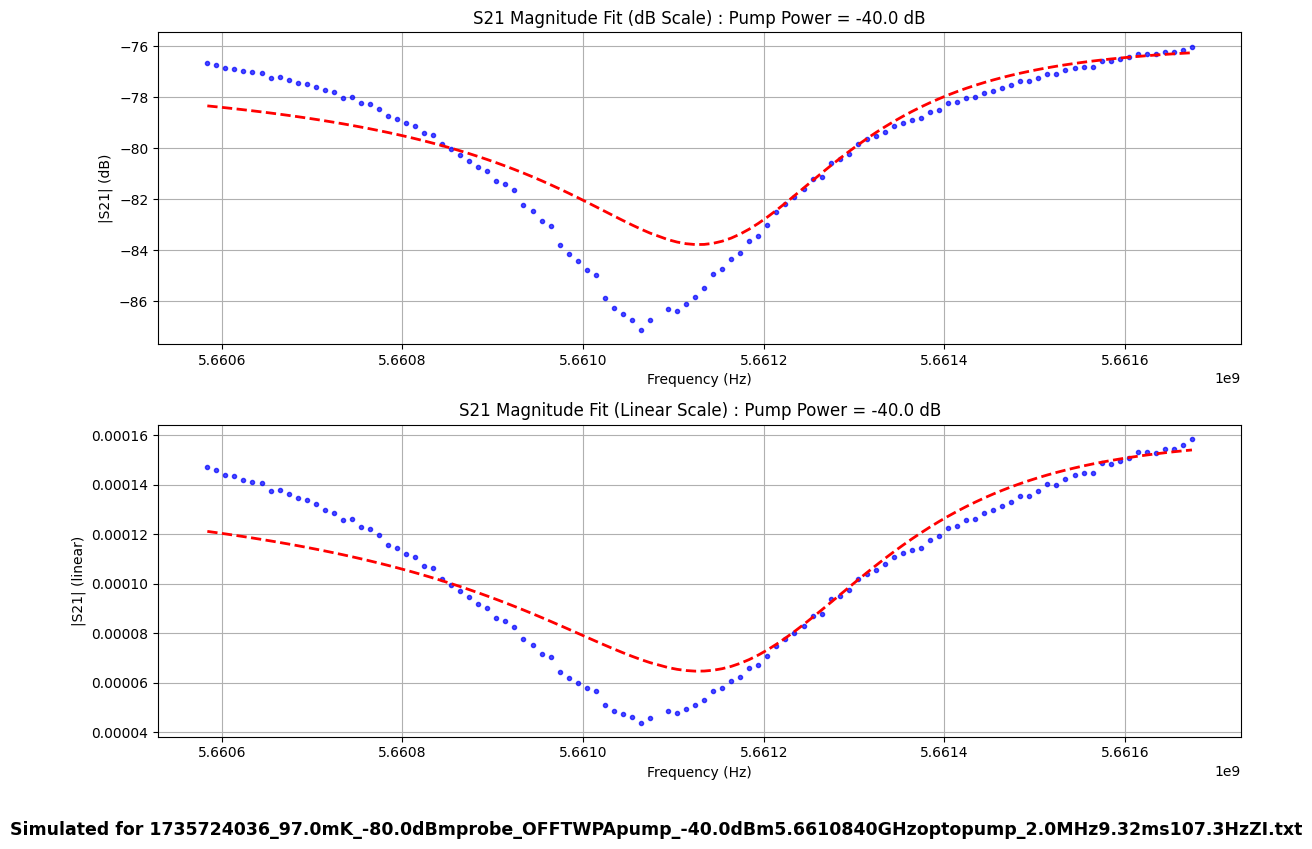

=== Analysis Results for 1735742350_97.0mK_-70.0dBmprobe_OFFTWPApump_-40.0dBm5.6610840GHzoptopump_2.0MHz9.32ms107.3HzZI.txt ===
=== Fitted Parameters ===
Resonance frequency (Hz): 5.661251e+09
internal damping k₀ (Hz): 377967.6
Coupling rate k_ex (Hz): 220030.6
total damping k_tot (Hz): 597998.2
Amplitude scaling factor A: 0.000463


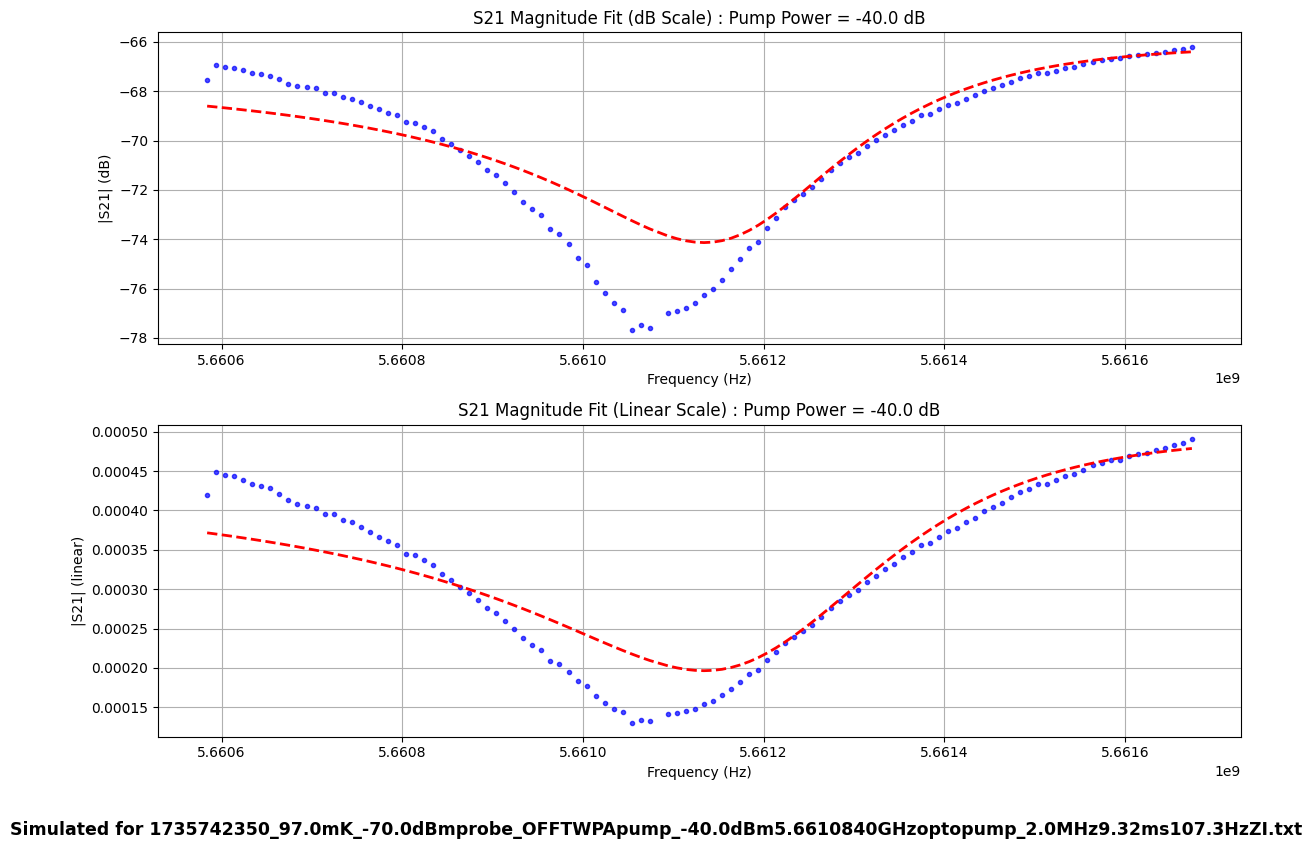

=== Analysis Results for 1735742482_97.0mK_-80.0dBmprobe_OFFTWPApump_-40.0dBm5.6610840GHzoptopump_2.0MHz9.32ms107.3HzZI.txt ===
=== Fitted Parameters ===
Resonance frequency (Hz): 5.661245e+09
internal damping k₀ (Hz): 380005.1
Coupling rate k_ex (Hz): 215747.6
total damping k_tot (Hz): 595752.7
Amplitude scaling factor A: 0.000148


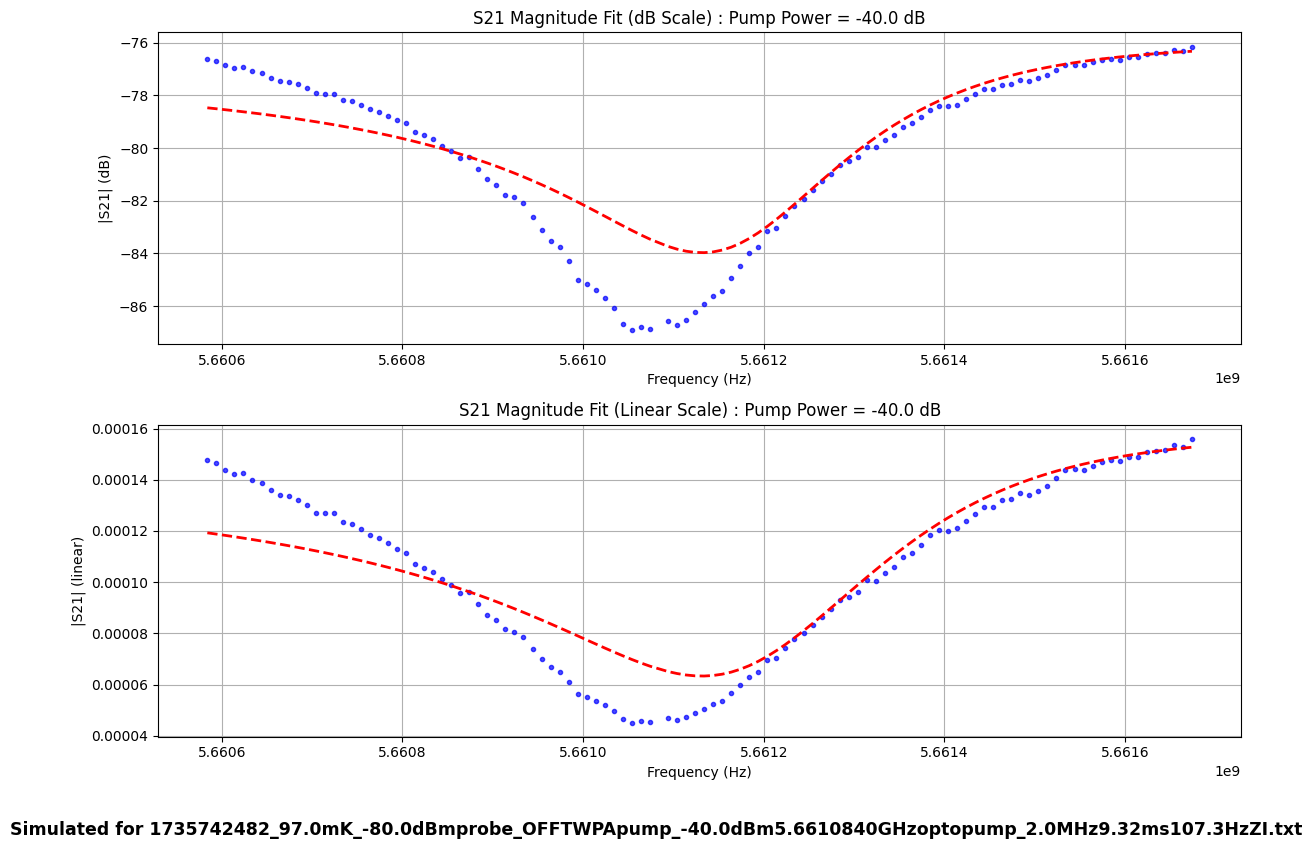

=== Analysis Results for 1735744694_97.0mK_-70.0dBmprobe_OFFTWPApump_-30.0dBm5.6611720GHzoptopump_2.0MHz9.32ms107.3HzZI.txt ===
=== Fitted Parameters ===
Resonance frequency (Hz): 5.661289e+09
internal damping k₀ (Hz): 408974.9
Coupling rate k_ex (Hz): 188850.4
total damping k_tot (Hz): 597825.3
Amplitude scaling factor A: 0.000515


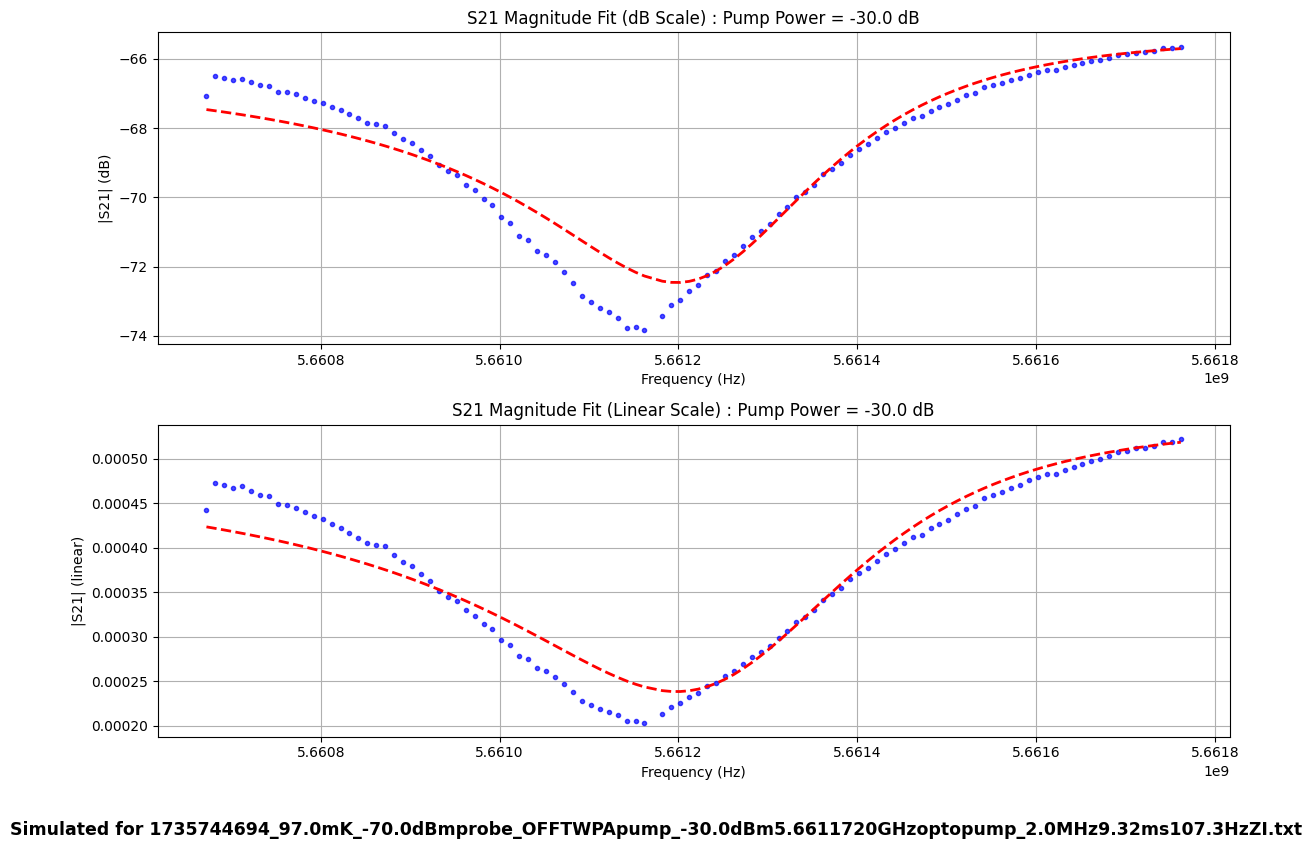

=== Analysis Results for 1735744826_97.0mK_-80.0dBmprobe_OFFTWPApump_-30.0dBm5.6611720GHzoptopump_2.0MHz9.32ms107.3HzZI.txt ===
=== Fitted Parameters ===
Resonance frequency (Hz): 5.661283e+09
internal damping k₀ (Hz): 411291.0
Coupling rate k_ex (Hz): 181271.3
total damping k_tot (Hz): 592562.4
Amplitude scaling factor A: 0.000164


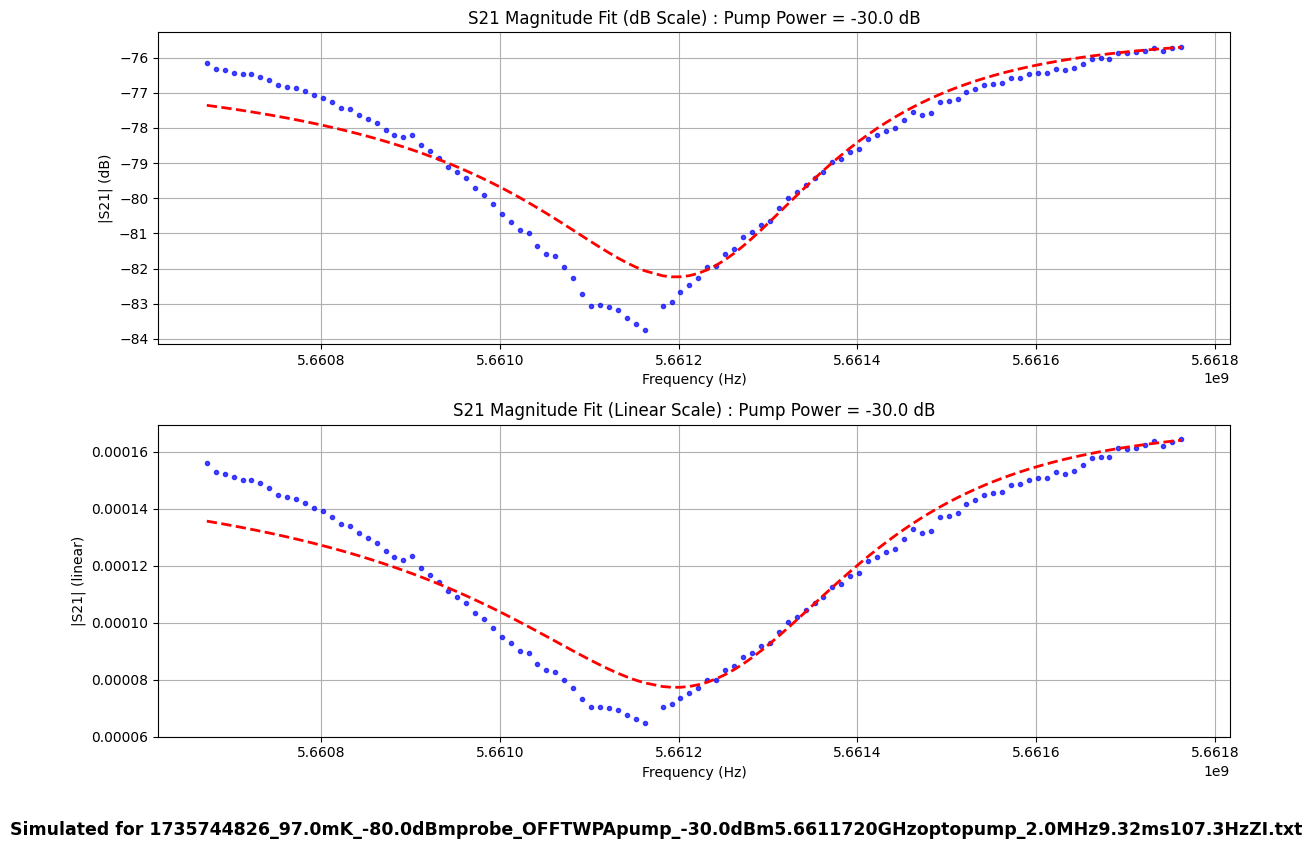

=== Analysis Results for 1735808070_97.0mK_-70.0dBmprobe_OFFTWPApump_-30.0dBm5.6611720GHzoptopump_2.0MHz9.32ms107.3HzZI.txt ===
=== Fitted Parameters ===
Resonance frequency (Hz): 5.661292e+09
internal damping k₀ (Hz): 409045.8
Coupling rate k_ex (Hz): 182743.9
total damping k_tot (Hz): 591789.6
Amplitude scaling factor A: 0.000524


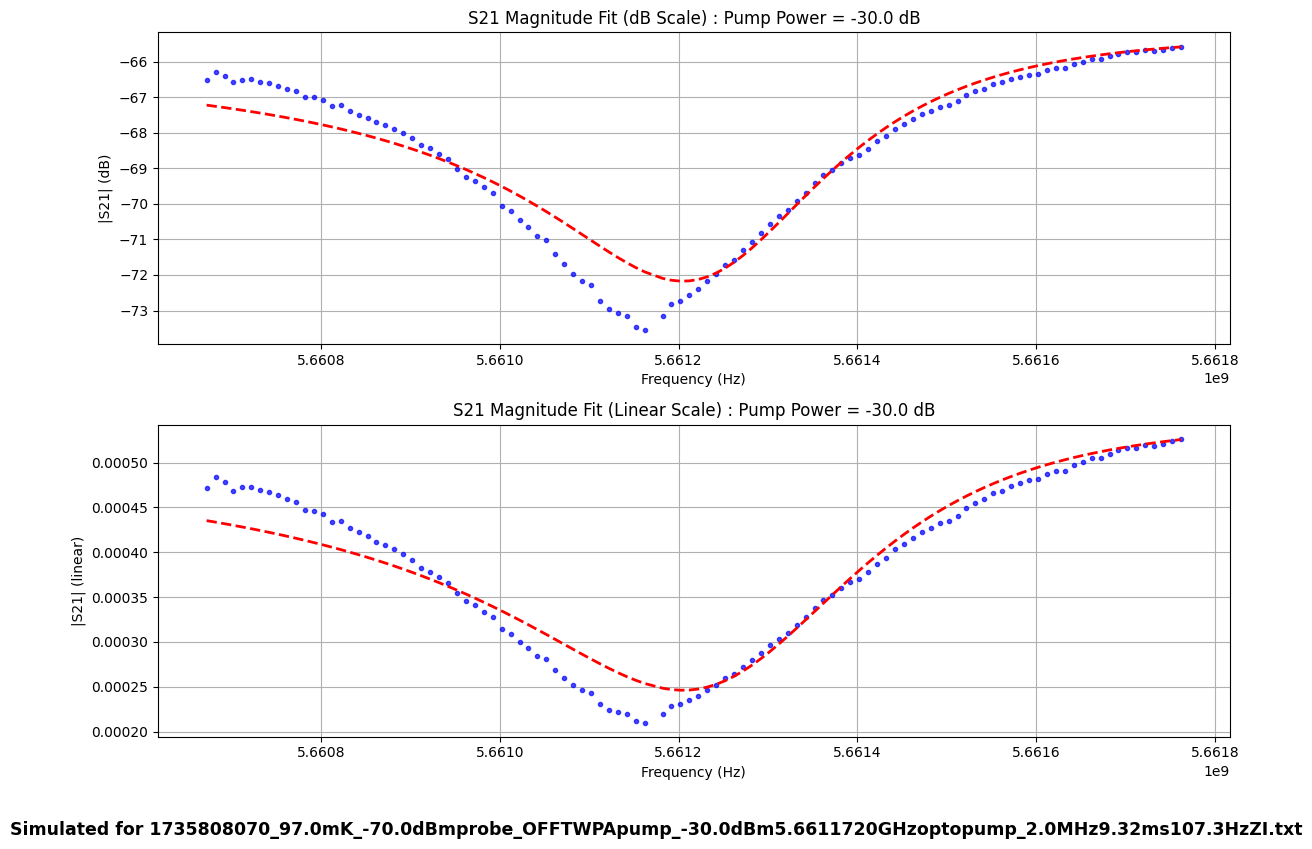

=== Analysis Results for 1735808203_97.0mK_-80.0dBmprobe_OFFTWPApump_-30.0dBm5.6611720GHzoptopump_2.0MHz9.32ms107.3HzZI.txt ===
=== Fitted Parameters ===
Resonance frequency (Hz): 5.661288e+09
internal damping k₀ (Hz): 412706.3
Coupling rate k_ex (Hz): 179967.8
total damping k_tot (Hz): 592674.2
Amplitude scaling factor A: 0.000168


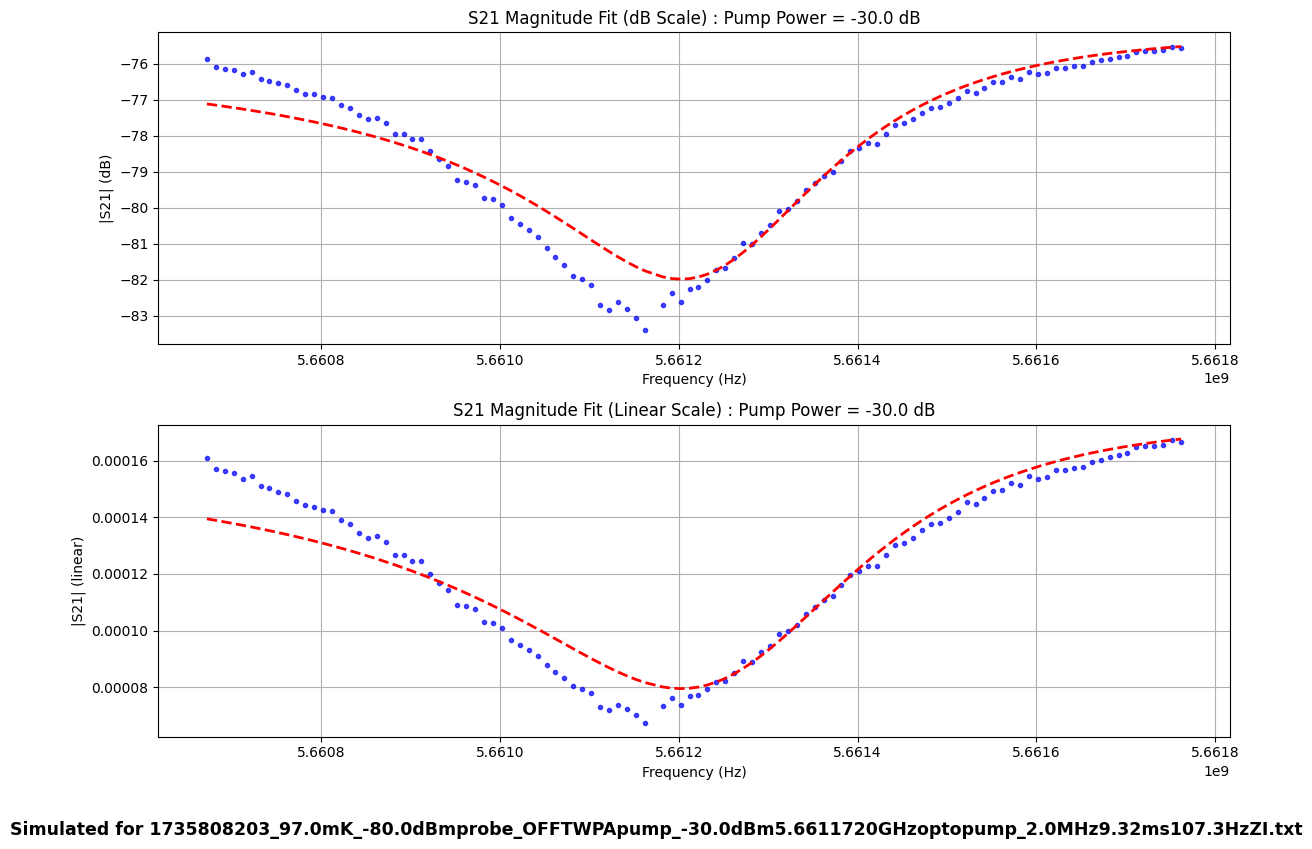

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import leastsq


folder='EPFL sample B 5.668 GHz 97 mK reflection'
filenames01=['1735723904_97.0mK_-70.0dBmprobe_OFFTWPApump_-40.0dBm5.6610840GHzoptopump_2.0MHz9.32ms107.3HzZI.txt', 
           "1735724036_97.0mK_-80.0dBmprobe_OFFTWPApump_-40.0dBm5.6610840GHzoptopump_2.0MHz9.32ms107.3HzZI.txt",
           '1735742350_97.0mK_-70.0dBmprobe_OFFTWPApump_-40.0dBm5.6610840GHzoptopump_2.0MHz9.32ms107.3HzZI.txt',
           '1735742482_97.0mK_-80.0dBmprobe_OFFTWPApump_-40.0dBm5.6610840GHzoptopump_2.0MHz9.32ms107.3HzZI.txt',
          ]
filenames02=[ '1735744694_97.0mK_-70.0dBmprobe_OFFTWPApump_-30.0dBm5.6611720GHzoptopump_2.0MHz9.32ms107.3HzZI.txt',
           '1735744826_97.0mK_-80.0dBmprobe_OFFTWPApump_-30.0dBm5.6611720GHzoptopump_2.0MHz9.32ms107.3HzZI.txt',
           '1735808070_97.0mK_-70.0dBmprobe_OFFTWPApump_-30.0dBm5.6611720GHzoptopump_2.0MHz9.32ms107.3HzZI.txt',
           '1735808203_97.0mK_-80.0dBmprobe_OFFTWPApump_-30.0dBm5.6611720GHzoptopump_2.0MHz9.32ms107.3HzZI.txt']

pump_power= -40.0 # dBm
for filename in filenames01:
    freq=[]
    S11=[]
    f=open(folder+'\\'+filename,'r')
    data=f.readlines()
    f.close()
    for line in data[1:]:
            fields=line.split('\t')
            freq.append(float(fields[0]))
            S11.append(float(fields[1]))
    freq=array(freq)
    logMag=array(S11)
    # freq_clean, logMag_clean = remove_outlier_points(freq, logMag)
    p_fitted = analyze_s21_logmag(freq, logMag, pump_power,filename)

pump_power = -30.0 # dBm
for filename in filenames02:
    freq=[]
    S11=[]
    f=open(folder+'\\'+filename,'r')
    data=f.readlines()
    f.close()
    for line in data[1:]:
                fields=line.split('\t')
                freq.append(float(fields[0]))
                S11.append(float(fields[1]))
    freq=array(freq)
    logMag=array(S11)
    # freq_clean, logMag_clean = remove_outlier_points(freq, logMag)
    p_fitted = analyze_s21_logmag(freq, logMag, pump_power,filename)